# Import Packages

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from gensim.models.word2vec import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split



# Import Cleaned Data

In [2]:
data_clean = pd.read_csv('data_clean.csv')
data_clean.sample(frac=1)
Characters_per_rank = (data_clean.Characters.value_counts()).index 
#data_clean = data_clean[:20000]
data_clean.shape

(49739, 6)

In [ ]:
# Select and Label Dataset for Modeling

In [3]:
threshold = 7
names={0:'MONICA', 1:'JOEY', 2:'CHANDLER', 3:'PHOEBE',4:'RACHEL',5:'ROSS',6:'Others'}
names_rev={'MONICA':0, 'JOEY':1, 'CHANDLER':2, 'PHOEBE':3,'RACHEL':4,'ROSS':5,'Others':6}

data_thres = data_clean
data_thres['Characters']= data_clean['Characters'].apply(lambda x: 'Others' if (x not in names.values()) else x)

data_thres['target'] = data_thres.apply(lambda x: names_rev.get(x.Characters),axis=1)
data_thres[:10]

,Unnamed: 0,Episodes,Episode_Names,Characters,Lines,Season,target
0,0,101,Monica Gets A Roommate,MONICA,there's nothing tell he's guy work,1,0
1,1,101,Monica Gets A Roommate,JOEY,c'mon go guy there's gotta something wrong,1,1
2,2,101,Monica Gets A Roommate,CHANDLER,right joey nice hump hump hairpiece,1,2
3,3,101,Monica Gets A Roommate,PHOEBE,wait eat chalk,1,3
4,4,101,Monica Gets A Roommate,PHOEBE,cause want go go carl oh,1,3
5,5,101,Monica Gets A Roommate,MONICA,okay everybody relax even date two people go d...,1,0
6,6,101,Monica Gets A Roommate,CHANDLER,sound like date,1,2
7,7,101,Monica Gets A Roommate,CHANDLER,alright i'm back high school i'm stand middle ...,1,2
8,8,101,Monica Gets A Roommate,Others,oh yeah dream,1,6
9,9,101,Monica Gets A Roommate,CHANDLER,look realize there's phone,1,2


In [4]:
# split the clean text in the rows  into list of words
tokenized_data = data_thres["Lines"].apply(lambda text: re.split(' ',text))

target_thres = data_thres['target'] 
my_tags = data_thres['Characters'].unique()
my_tags

array(['MONICA', 'JOEY', 'CHANDLER', 'PHOEBE', 'Others', 'ROSS', 'RACHEL'],
      dtype=object)

In [ ]:
data_thres.head()

,Unnamed: 0,Episodes,Episode_Names,Characters,Lines,Season,target
0,0,101,Monica Gets A Roommate,MONICA,there's nothing tell he's guy work,1,0
1,1,101,Monica Gets A Roommate,JOEY,c'mon go guy there's gotta something wrong,1,1
2,2,101,Monica Gets A Roommate,CHANDLER,right joey nice hump hump hairpiece,1,2
3,3,101,Monica Gets A Roommate,PHOEBE,wait eat chalk,1,3
4,4,101,Monica Gets A Roommate,PHOEBE,cause want go go carl oh,1,3


# Feature Engineering using Word2Vec Embedding

## Word2Vec with TFIDF weighting scheme

In [5]:
# Define a class to impelement word2vec averaged with tf-idf weighting scheme

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y = None):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.wv[w] * self.word2weight[w]
                         for w in words if w in self.word2vec.wv] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [6]:

# let X be a list of tokenized texts (i.e. list of lists of tokens)
model = Word2Vec(tokenized_data,min_count=2,size=100,window=5,iter=100)

tfidf_word2vec = TfidfEmbeddingVectorizer(model)
tfidf_word2vec.fit(tokenized_data)
tfidf_doc_vec = tfidf_word2vec.transform(tokenized_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys


In [7]:
model.similarity('dream','realize')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.12626472

## Word2Vec with Simple Averaging Scheme

In [8]:
# Define a class to impolement word2vec with simple averaging scheme
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [9]:
word_model = Word2Vec(tokenized_data,min_count=2,size=100,window=5,iter=100)
mean_vec_tr = MeanEmbeddingVectorizer(word_model)
doc_vec = mean_vec_tr.transform((tokenized_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [14]:
word2vec_map = {'Word2Vec': doc_vec, 'Word2Vec with TF-IDF Weighting':tfidf_doc_vec}

## Plot Confusion Matrix

In [ ]:
def plot_cm(y_true, y_pred, figsize=(15, 15)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

## Saving Model to Disk

In [19]:
import pickle
def save_model(model,filename):
  pickle.dump(model, open(filename+".sav", 'wb'))

# ML Modeling Performance with Word2vec

In [ ]:
def word_embedding_performance_eval(clf,X,Y):
    Eval_score =  cross_val_score(clf,X,Y, cv=5)
    return  Eval_score.mean() 
    
model =  LogisticRegression(max_iter = 1e6)
print("Train Accuracies:")
for key,val in word2vec_map.items():
  x_train, x_test, y_train, y_test = train_test_split(val,target_thres,test_size = 0.2,random_state =42)
  Accuracy = word_embedding_performance_eval(model,x_train,y_train)
  print(key)
  print(Accuracy)

Train Accuracies:
Word2Vec
0.20818782525838236
Word2Vec with TF-IDF Weighting
0.20831338392624854


## Accuracy for Logistic Regression

In [12]:
model_lr =  LogisticRegression(max_iter = 1e6)

In [25]:
from sklearn.metrics import accuracy_score
for key,val in word2vec_map.items():
  x_train, x_test, y_train, y_test = train_test_split(val,target_thres,test_size = 0.2,random_state =42)
  model_lr.fit(x_train,y_train)
  y_pred = model_lr.predict(x_test)
  print(key)
  print(accuracy_score(y_test, y_pred))
  save_model(model_lr,key+"_lr")



Word2Vec
0.20958986731001206
Word2Vec with TF-IDF Weighting
0.20969039002814635


# ROC LR

In [ ]:
from sklearn.metrics import roc_auc_score
for key,val in word2vec_map.items():
  x_train, x_test, y_train, y_test = train_test_split(val,target_thres,test_size = 0.2,random_state =42)
  y_prob = model_lr.predict_proba(x_test)
  print(key,roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro"))

Word2Vec 0.5614588016930476
Word2Vec with TF-IDF Weighting 0.5789768211528666


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[286, 184, 166,  48, 369, 230,  67],
       [184, 336, 137,  62, 363, 260,  58],
       [215, 240, 233,  53, 370, 240,  78],
       [185, 158, 129, 106, 410, 245,  54],
       [236, 168, 147,  63, 661, 273,  73],
       [186, 254, 150,  47, 412, 386,  83],
       [191, 208, 147,  49, 384, 266,  98]])

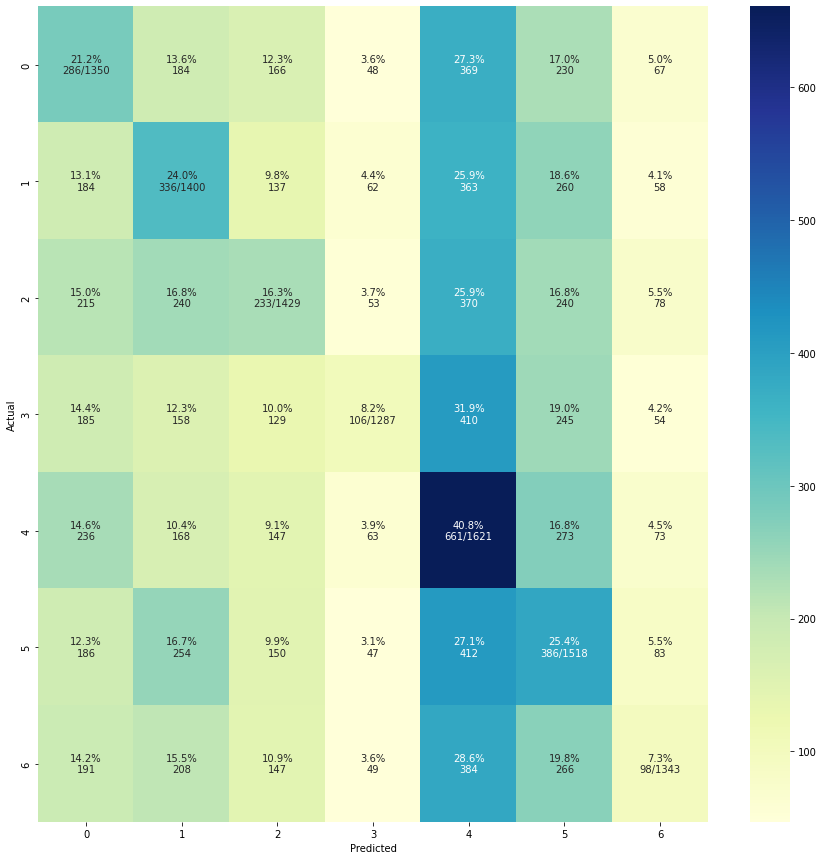

In [ ]:
plot_cm(y_test, y_pred)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(target_thres):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

## Optimize Logistic Regression for Best BOW/ Word Embedding Approach

In [ ]:

#model =  LogisticRegression(max_iter = 1e6)
#params_log = { "C": [1e-2,1, 10, 1e2,1e6]}

#grid_log = GridSearchCV(model, param_grid=params_log, cv=5)
#grid_log.fit(tfidf_df,target_thres)

#print(grid_log.best_score_)
#print(grid_log.best_params_)

# Prediction Accuracy of Other ML Models 

## Naive Bayes with Word2vec


In [ ]:
target_thres.unique()

array([0, 1, 2, 3, 6, 5, 4])

In [ ]:
for key,val in word2vec_map.items():
  x_train, x_test, y_train, y_test = train_test_split(val,target_thres,test_size = 0.2,random_state =42)
  model = GaussianNB()
  print(cross_val_score(model,x_train,y_train, cv=5).mean())

0.17890981933325611
0.1703652682677789


In [ ]:
# GridSearch with Naive Bayes
def gridsearchNB(clf, X, y):

    #the grid of parameters to search over
    smoothing = [0.00000001, 0.000000001, 0.00000001]
    #Find the best value for alpha and min_df, and the best classifier
    best_alpha = None
    maxscore=-np.inf
    for alpha in smoothing:        
        clf = GaussianNB(var_smoothing=alpha)
        cvscore = max(cross_val_score(clf, X,y,cv = 5))
        if cvscore > maxscore:
                maxscore = cvscore 
                best_alpha = alpha
    return  best_alpha, maxscore

print("Best Case with Count Vectorizer: ", gridsearchNB(model,doc_vec, target_thres))

Best Case with Count Vectorizer:  (1e-08, 0.1885806192199437)


## Accuracy for NB

In [24]:
from sklearn.metrics import accuracy_score
model_nb = GaussianNB(var_smoothing=1e-08)
for key,val in word2vec_map.items():
  x_train, x_test, y_train, y_test = train_test_split(val,target_thres,test_size = 0.2,random_state =42)
  model_nb.fit(x_train,y_train)
  y_pred = model_nb.predict(x_test)
  accuracy_score(y_test, y_pred)
  print(key,accuracy_score(y_test, y_pred))
  save_model(model_nb,key+"_nb_frnds")

Word2Vec 0.18677121029352634
Word2Vec with TF-IDF Weighting 0.17782468837957377


# ROC NB

In [ ]:
from sklearn.metrics import roc_auc_score
for key,val in word2vec_map.items():
  x_train, x_test, y_train, y_test = train_test_split(val,target_thres,test_size = 0.2,random_state =42)
  y_prob = model_nb.predict_proba(x_test)
  print(key,roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro"))

Word2Vec 0.5490953134856795
Word2Vec with TF-IDF Weighting 0.5508633166119928


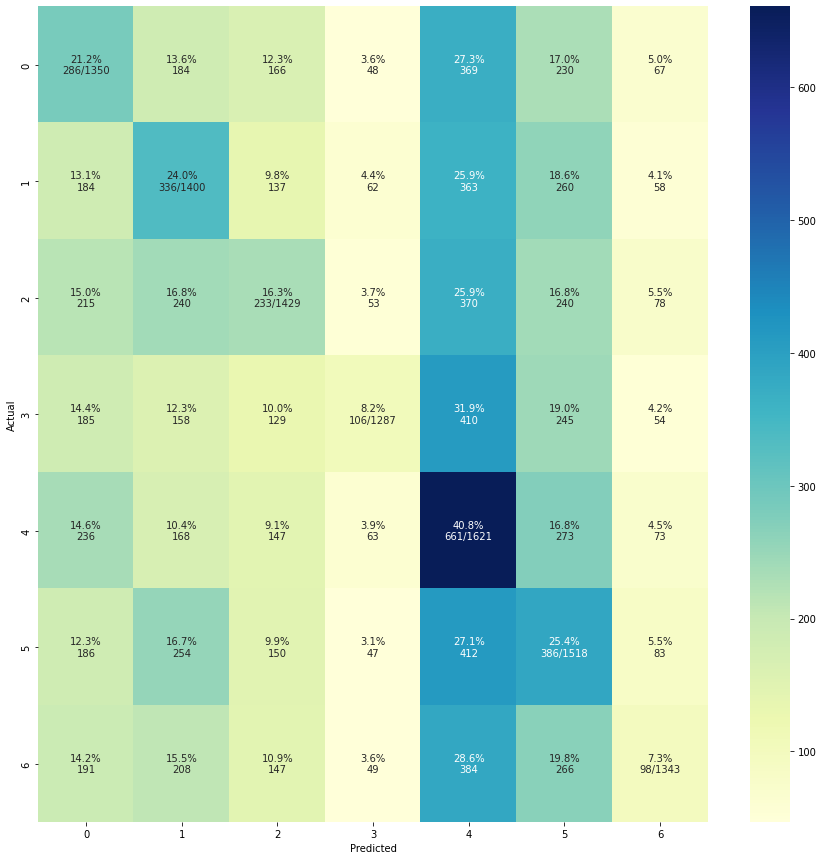

In [ ]:
plot_cm(y_test, y_pred)

## Support Vector Machine: 

In [ ]:
model_svc =SVC()
for key,val in word2vec_map.items():
  x_train, x_test, y_train, y_test = train_test_split(val,target_thres,test_size = 0.2,random_state =42)
  print('Accuracy of Support Vector Machine without Gridsearch:', cross_val_score(model_svc,x_train,y_train, cv=5).mean())

Accuracy of Support Vector Machine without Gridsearch: 0.22927294417061606
Accuracy of Support Vector Machine without Gridsearch: 0.22866979964956746


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(doc_vec,target_thres,test_size = 0.2,random_state =42)

In [ ]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
#kernels =  ['rbf','linear']
params_svc = {'C': Cs, 'gamma' : gammas}
grid_svc = GridSearchCV(SVC(), param_grid = params_svc, cv=5)
grid_svc.fit(x_train,y_train)
print('Optimized Modeling Paramters for Support vector Machine', grid_svc.best_params_)
print('Accuracy of Support Vector Machine with Gridsearch:', grid_svc.best_score_)

In [23]:
for key,val in word2vec_map.items():
  x_train, x_test, y_train, y_test = train_test_split(val,target_thres,test_size = 0.2,random_state =42)
  model = SVC(probability=True)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  print('Accuracy of Support Vector Machine:', key, accuracy_score(y_test, y_pred))
  save_model(model_nb,key+"_svm_frnds")

Accuracy of Support Vector Machine: Word2Vec 0.23421793325291515
Accuracy of Support Vector Machine: Word2Vec with TF-IDF Weighting 0.2317048652995577


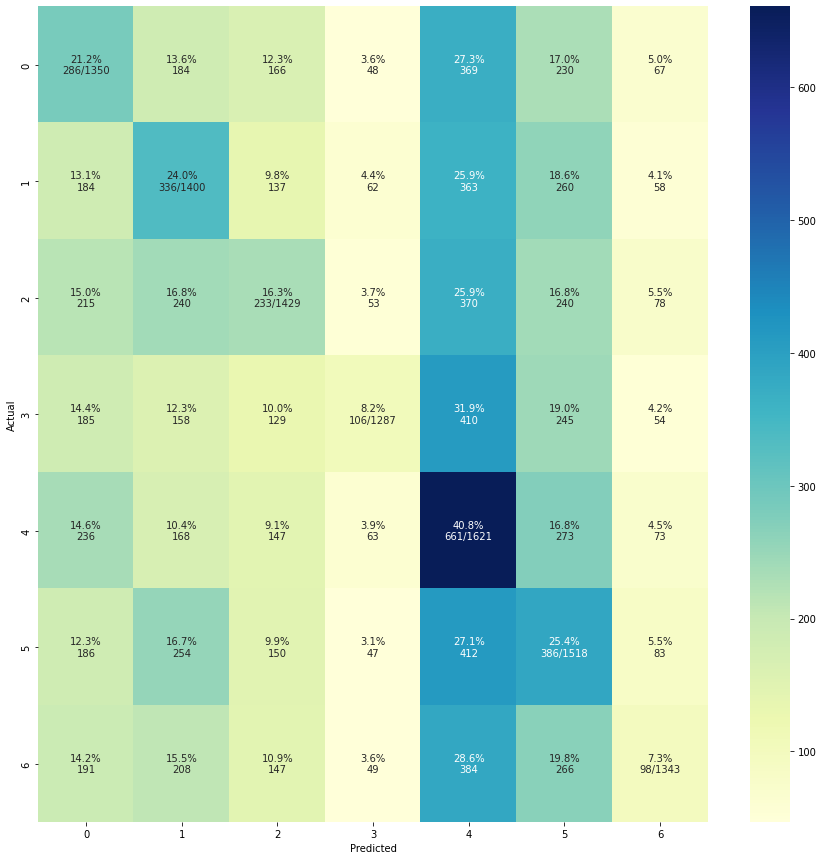

In [ ]:
plot_cm(y_test, y_pred)

# ROC SVM

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = model.predict_proba(x_test)
roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")

0.6124280744086654

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

y= label_binarize(target_thres, classes = list(set(target_thres)))
n_classes = y.shape[1]
# split training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(doc_vec, y, test_size=.5,
                                                    random_state=0)

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

y= label_binarize(target_thres, classes = list(set(target_thres)))
n_classes = y.shape[1]
# split training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(doc_vec, y, test_size=.2,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(x_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


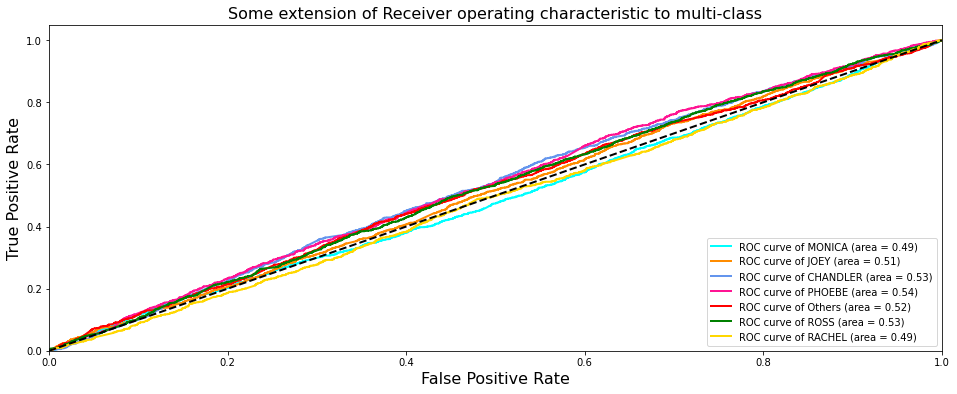

In [ ]:
plt.figure(figsize = (16,6))
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','deeppink', 'red', 'green','gold','purple','olivedrab','mediumslateblue','gray','lawngreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(my_tags[i], roc_auc[i]))
        
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',FontSize = 16)
plt.ylabel('True Positive Rate',FontSize = 16)
plt.title('Some extension of Receiver operating characteristic to multi-class',FontSize = 16)
plt.legend(loc="lower right")
plt.show()

# ROC Curve for Oversampled Data

In [10]:
%%time

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler

Sampling =  RandomOverSampler(random_state=0)

y= label_binarize(target_thres, classes = list(set(target_thres)))
n_classes = y.shape[1]
# split training and test sets
x_train, x_test, y_train, y_test = train_test_split(doc_vec, y, test_size=.5,
                                                    random_state=0)
x_train, y_train = Sampling.fit_resample(x_train,  y_train)
print (x_train.shape)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(x_train, y_train).decision_function(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


(27608, 100)
CPU times: user 35min 27s, sys: 2.25 s, total: 35min 29s
Wall time: 35min 29s


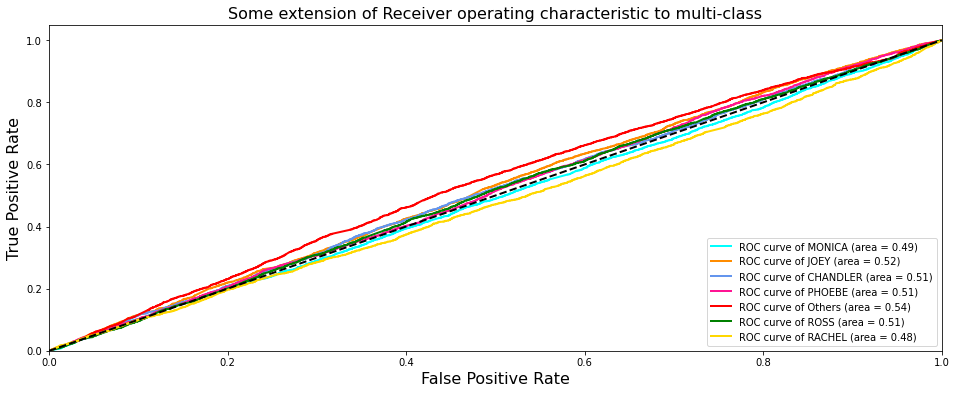

In [11]:
plt.figure(figsize = (16,6))
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','deeppink', 'red', 'green','gold','purple','olivedrab','mediumslateblue','gray','lawngreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(my_tags[i], roc_auc[i]))
        
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',FontSize = 16)
plt.ylabel('True Positive Rate',FontSize = 16)
plt.title('Some extension of Receiver operating characteristic to multi-class',FontSize = 16)
plt.legend(loc="lower right")
plt.show()